# My InstaCart Data Story

The following notebook is the culmination of my Exploratory Analysis of the InstaCart Market Basket Analysis.

The data contains information on products, aisles, departments and sales.  It also included whether or not the User reordered the product and in what sequence it was added to their cart.  Time series data is also available and informs us of how often people shop and when.

The following is focussed on the general trends of the dataset and does not delve in to the machine learning applications of predicting purchases.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dfOrders=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/orders.csv')
dfDept=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/departments.csv')
dfOrdersPrior=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/order_products__prior.csv')
dfAisles=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/aisles.csv')
dfProd=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/products.csv')
dfOrdersTrain=pd.read_csv('/Users/acmilne/Documents/Python-Data-Science-and-Machine-Learning-Bootcamp/Groceries/order_products__train.csv')

In [3]:
dfOrdersTrain.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
dfOrdersPrior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
dfOrders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
dfDept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
dfAisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [8]:
dfProd.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# How many products are there?

There are nearly 50,000 products available on the app.

In [9]:
dfProd['product_id'].unique()


array([    1,     2,     3, ..., 49686, 49687, 49688])

# For later in this notebook:

Build an array that contains all the products, aisles and departments...

In [10]:
dfShelves = dfProd.merge(dfAisles).sort_values(by='product_name')
dfShelves = dfShelves.merge(dfDept).sort_values(by='product_name')
dfShelves.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,25773,#2 Coffee Filters,26,7,coffee,beverages
1,2158,#2 Cone White Coffee Filters,26,7,coffee,beverages
4365,26685,#2 Mechanical Pencils,87,17,more household,household
2,26381,#4 Natural Brown Coffee Filters,26,7,coffee,beverages
7450,20604,& Go! Hazelnut Spread + Pretzel Sticks,88,13,spreads,pantry


# What's the weekly shopping profile?
Interestingly the shoppers are typically purchasing on Sunday and Monday of each week.

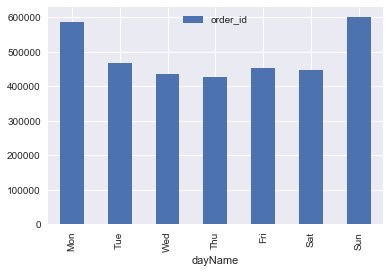

In [11]:
days = {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'} #dictionary of numeric day:Alpha day
week = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun']

a = dfOrders #set new df equal to orders df
a['dayName']=a['order_dow'].apply(lambda x: days[x]) #create new column 'dayName' compare' order_dow' to dictionary
a = a.groupby(['dayName'])[['order_id']].count().reindex(week).plot.bar() #group the orders by dayName


# What time of day do people shop?
They are generally shopping in the early afternoon.

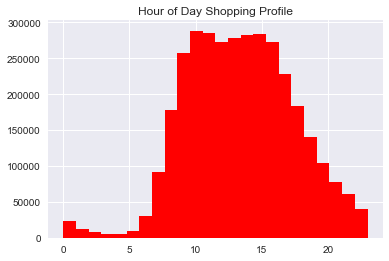

In [119]:
dfOrders['order_hour_of_day'].hist(bins=24,color='red')
plt.title("Hour of Day Shopping Profile")

In [13]:
dfOrders['order_hour_of_day'].describe()

count    3.421083e+06
mean     1.345202e+01
std      4.226088e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.300000e+01
75%      1.600000e+01
max      2.300000e+01
Name: order_hour_of_day, dtype: float64

# How often are people shopping?
On average people place orders every 11 days.  There is an interesting spike towards the 30 day mark.  This may be worth investigating further.

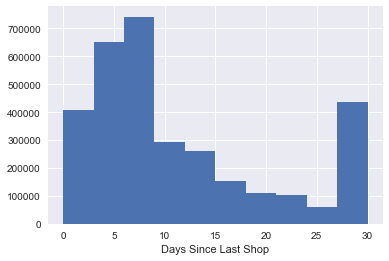

In [120]:
dfOrders['days_since_prior_order'].hist()
plt.xlabel("Days Since Last Shop")

In [15]:
dfOrders['days_since_prior_order'].describe()

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

# Which Department is the most popular for purchases?
Produce is where people shop the most.  The number of purchases outpaces snacks by a long way even though there are equivalent number of products in each department as we will see later.

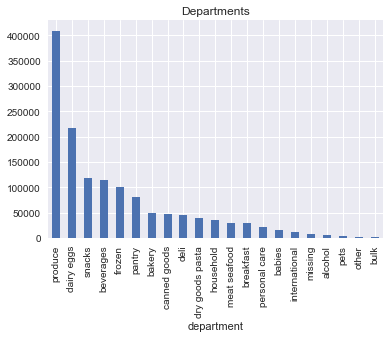

In [126]:
dfFun=dfOrdersTrain.merge(dfShelves) #combine the prior orders & shelf contents
a=dfFun.groupby(['department']).size().sort_values(ascending=False) #groupby department
a.plot(kind='bar',title='Departments')
#shows the most popular departments

# How are these sales reflected in each aisle?
I have developed a treemap in Tableau to illustrate the answer
<img src="files/DeptAislebySales.png">
People love to shop for:
 - Fresh Fruit and Veg
 - Chips and Pretzels
 - Sparkling Water
 - Ice Cream
 - Yogurt

# Which products do people buy most often?
The banana is the most popular product.

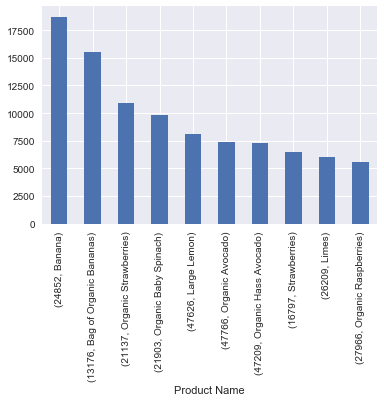

In [123]:
b=dfFun.groupby(['product_id','product_name']).size().sort_values(ascending=False)
b.head(10).plot.bar()
plt.xlabel("Product Name")

Another way of visualizing this is using a bubble chart made in Tableau
<img src="files/ProductbySalesBubble.png">

Alternatively a treemap could be used
<img src="files/ProductbySales.png">

# Which departments have the largest selection of products?
Personal care and snacks have the largest number of SKUs

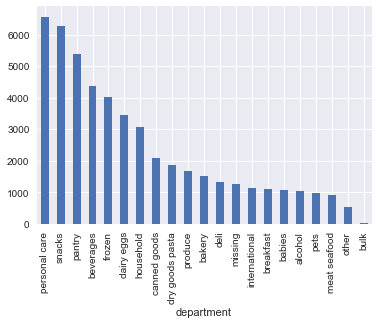

In [124]:
ProductVolume= dfShelves.groupby(['department']).size().sort_values(ascending=False)
ProductVolume.plot(kind='bar')

# Which products have the highest likelihood of being reordered?

I have produced a table and bar chart of the results.

The analysis was done by first calculating the mean of the products reordered data.  In order to clean out the small sample sizes I filtered out items that had purchases less than 40 times.


In [31]:
c=dfOrdersTrain.groupby(['product_id'],as_index=False)['reordered'].agg('mean')
c.rename(columns={'product_id':'product_id','reordered':'prop_reordered'},inplace=True)
my_list=dfOrdersTrain.groupby(['product_id'],as_index=False)['order_id'].count()
my_list.rename(columns={'product_id':'product_id','order_id':'order_count'},inplace=True)
d=c.merge(my_list,on='product_id')
r=d[(d['prop_reordered']!=1) & (d['order_count']>40)]
r=r.merge(dfProd,on='product_id')
r.sort_values(by='prop_reordered',ascending=False).head(10)

,product_id,prop_reordered,order_count,product_name,aisle_id,department_id
170,1729,0.934783,92,2% Lactose Free Milk,84,16
2237,20940,0.913043,368,Organic Low Fat Milk,84,16
1300,12193,0.898305,59,100% Florida Orange Juice,98,7
3401,31764,0.888889,45,Original Sparkling Seltzer Water Cans,115,7
2249,21038,0.888889,81,Organic Spelt Tortillas,128,3
2666,24852,0.884172,18726,Banana,24,4
13,117,0.883333,120,Petit Suisse Fruit,2,16
4256,39180,0.881988,483,Organic Lowfat 1% Milk,84,16
1326,12384,0.881041,269,Organic Lactose Free 1% Lowfat Milk,91,16
2594,24024,0.878525,461,1% Lowfat Milk,84,16


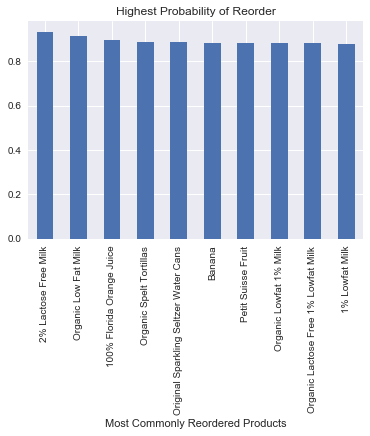

In [125]:
r.set_index('product_name')['prop_reordered'].sort_values(ascending=False).head(10).plot.bar(title='Highest Probability of Reorder')
plt.xlabel("Most Commonly Reordered Products")

The most reordered products are shown in the bar chart above.

# What relationship might exist between likelihood of reorder and days since prior order?

See the plot below, if the shopper purchases again within a week it is more likely a product will be reordered.

<img src="files/ReorderedbyDaysSince.png">

# How has the dataset been split up?
There are 3.4M prior orders in the dataset and they have been split up in to a training set, historical set and test set.

In [22]:
dfOrders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

# How many Items do people usually buy?
The average purchase is 10 items

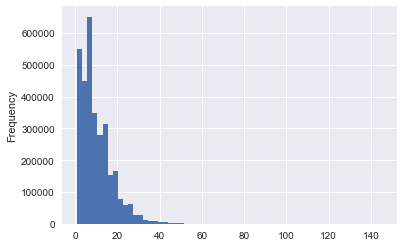

In [23]:
dfQtyBought = dfOrdersPrior.groupby(['order_id']).last()
dfQtyBought.reset_index()
dfQty = dfQtyBought['add_to_cart_order']
dfQty.plot.hist(bins=60)

In [24]:
dfQty.describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: add_to_cart_order, dtype: float64

# Which items are most popular as a first selection?

We would expect the banana to be high on the list but spring water and soda also feature high on the list.

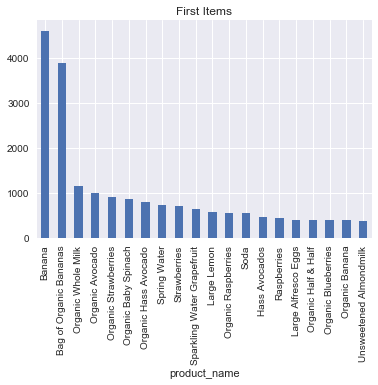

In [114]:
test = dfOrdersTrain.groupby(['add_to_cart_order','product_id'],as_index=False).count()
first_item=test.set_index('add_to_cart_order').sort_values(by=['order_id'],ascending=False)
ok=first_item.ix[1].head(20)
ok=ok.merge(dfProd,on='product_id')
ok.set_index('product_name')['order_id'].plot.bar(title='First Items')

# What's the craziest chart we can make with the data?
Here is a bubble chart of all products by their departments and relative sales...it makes for an orbital impression...I thought it was neat to look at more than anything.

<img src="files/ProductOrbits.png">

The data behind this story can be located at the following URL:
https://www.kaggle.com/c/instacart-market-basket-analysis